# Biases of extreme values

- This notebook aims to quantify sWBGT/ESI biases in measure extreme heat stress.


- We fit a GEV distribution of annual maximum sWBGT, ESI and WBGT during 1990-2019, and estimate the 30-year return level for all metrics and compare them with each other.


- In this notebook, we will reproduce Figure 5 in "Explicit Calculations of Wet Bulb Globe Temperature compared with approximations and why it matters for labor productivity" by Qinqin Kong and Matthew Huber. 

In [1]:
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cmaps
import regionmask
import cartopy.crs as ccrs

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import warnings
warnings.filterwarnings("ignore")

### Read in data:

In [3]:
# read in GEV 30year return level and the p-value of biases
gev=xr.open_dataset('/scratch/brown/kong97/paper_data/earthfuture_kong_huber_2021/GEV.nc')

### Reproduce Figure 5

In [4]:
# create land mask
mask = regionmask.defined_regions.natural_earth.land_110.mask(gev,lon_name="longitude",lat_name="latitude")

# create meshgrid of latitude and longitude
LON,LAT=np.meshgrid(gev.longitude,gev.latitude)

# function to plot each individual subplot
def subplot1(data,axis,norm,cmap):
    g=axis.pcolormesh(LON, LAT,data.where(mask==0),transform=ccrs.PlateCarree(),cmap=cmap,norm=norm,rasterized=True) # make the plot
    axis.coastlines(linewidth=0.5) # add coastlines
    axis.set_title('')
    axis.set_extent([-169.999,189.999,-60,70]) # set extent of the map to exclude high latitudes
    return g
def subplot2(data,pvalue,axis,norm,cmap):
    g=axis.pcolormesh(LON, LAT,data.where(mask==0),transform=ccrs.PlateCarree(),cmap=cmap,norm=norm,rasterized=True) # make the plot
    # overlay statistical significance with areas not significant being hatched
    pvalue.where(mask==0).plot.contourf(ax=axis,transform=ccrs.PlateCarree(),
                         colors='none',levels=[-0.5,0.5,1.5],hatches=['///',None],add_colorbar=False,alpha=0,rasterized=True)
    
    axis.coastlines(linewidth=0.5) # add coastlines
    axis.set_title('')
    axis.set_extent([-169.999,189.999,-60,70]) # set extent of the map to exclude high latitudes
    return g
def plot(gev):    
    # set colorbar scale
    levels1 = np.arange(-4,43,2)
    norm1=mpl.colors.BoundaryNorm(levels1,ncolors=len(levels1)+1,extend='both')
    # choose colormap
    cmap1=cmaps.StepSeq25.reversed()
    
    levels2 = [-7, -6, -5, -4, -3, -2, -1,-0.5,  0.5,  1,  2,  3,  4,  5,  6,  7]
    norm2=mpl.colors.BoundaryNorm(levels2,ncolors=len(levels2)+1,extend='both')
    # choose colormaps
    color=np.array([[8,29,88],
              [2,56,88],
              [4,90,141],
              [5,112,176],
              [54,144,192],
              [116,169,207],
              [166,189,219],
              [236,231,242],
              [255,255,255],
              [255,247,188],
              [254,196,79],
              [254,153,41],
              [236,112,20],
              [204,76,2],
              [153,52,4],
              [102,37,6],
              [223,101,176]])
    cmap2=mpl.colors.ListedColormap(color/255.)
    
    # create figure
    fig = plt.figure(figsize=[13, 12])
    # use gridspec to customize the layout of subplots
    spec = gridspec.GridSpec(ncols=6, nrows=2,width_ratios=[1,1,1,1,1,1], wspace=0.1,hspace=-1.05, height_ratios=[1,1])
    ax1 = fig.add_subplot(spec[0:2], projection=ccrs.Robinson(central_longitude=10))
    ax2 = fig.add_subplot(spec[2:4], projection=ccrs.Robinson(central_longitude=10))
    ax3 = fig.add_subplot(spec[4:6], projection=ccrs.Robinson(central_longitude=10)) 
    ax4 = fig.add_subplot(spec[7:9], projection=ccrs.Robinson(central_longitude=10))
    ax5 = fig.add_subplot(spec[9:11], projection=ccrs.Robinson(central_longitude=10))
    
    # add annotates
    fig.subplots_adjust(bottom=0, left=0,right=1, top=1,wspace=0.03)
    anno_opts = dict(xy=(0, 1.05), xycoords='axes fraction',va='center', ha='center')
    num=['a','b','c','d','e']
    i=0
    for ax in [ax1,ax2,ax3,ax4,ax5]:
        ax.annotate(num[i], **anno_opts,fontsize=16)
        i+=1
    
    # call subplot function
    g=subplot1(gev.wbgt-273.15,ax1,norm1,cmap1) # plot return values of wbgt
    subplot1(gev.swbgt-273.15,ax2,norm1,cmap1) # plot return values of swbgt
    subplot1(gev.esi,ax3,norm1,cmap1) # plot return values of esi
    
    # make colorbar
    cb1=fig.colorbar(g,ax=(ax1,ax2,ax3),orientation='horizontal', 
                     ticks=[-4,4,14,24,34,42],
                     pad=0.01,shrink=0.5,fraction=0.5,aspect=30)
    cb1.set_label(label="WBGT, sWBGT or ESI ($^\circ$C)", size=14)
    cb1.ax.tick_params(labelsize=12)
    
    # call subplot function
    h=subplot2(gev.swbgt_wbgt,gev.sig_swbgt_05,ax4,norm2,cmap2) # plot differences between return values of swbgt and wbgt
    subplot2(gev.esi_wbgt,gev.sig_esi_05,ax5,norm2,cmap2)  # plot differences between return values of esi and wbgt
    
    # make color bar
    cb2=fig.colorbar(h,ax=(ax4,ax5),orientation='horizontal', pad=0.01,shrink=0.8,fraction=0.2,aspect=30,
                     ticks=[ -6, -4, -2,-0.5,  0.5, 2, 4, 6],spacing='proportional') 
    cb2.set_label(label="sWBGT/ESI - WBGT ($^\circ$C)", size=14)
    cb2.ax.tick_params(labelsize=12)
    
    # add annonates
    anno_opts = dict(xy=(0.5, 1.1), xycoords='axes fraction',va='center', ha='center')    
    ax1.annotate('WBGT', **anno_opts,fontsize=16)
    ax2.annotate('sWBGT', **anno_opts,fontsize=16)
    ax3.annotate('ESI', **anno_opts,fontsize=16)
    ax4.annotate('sWBGT-WBGT', **anno_opts,fontsize=16)
    ax5.annotate('ESI-WBGT', **anno_opts,fontsize=16)
    

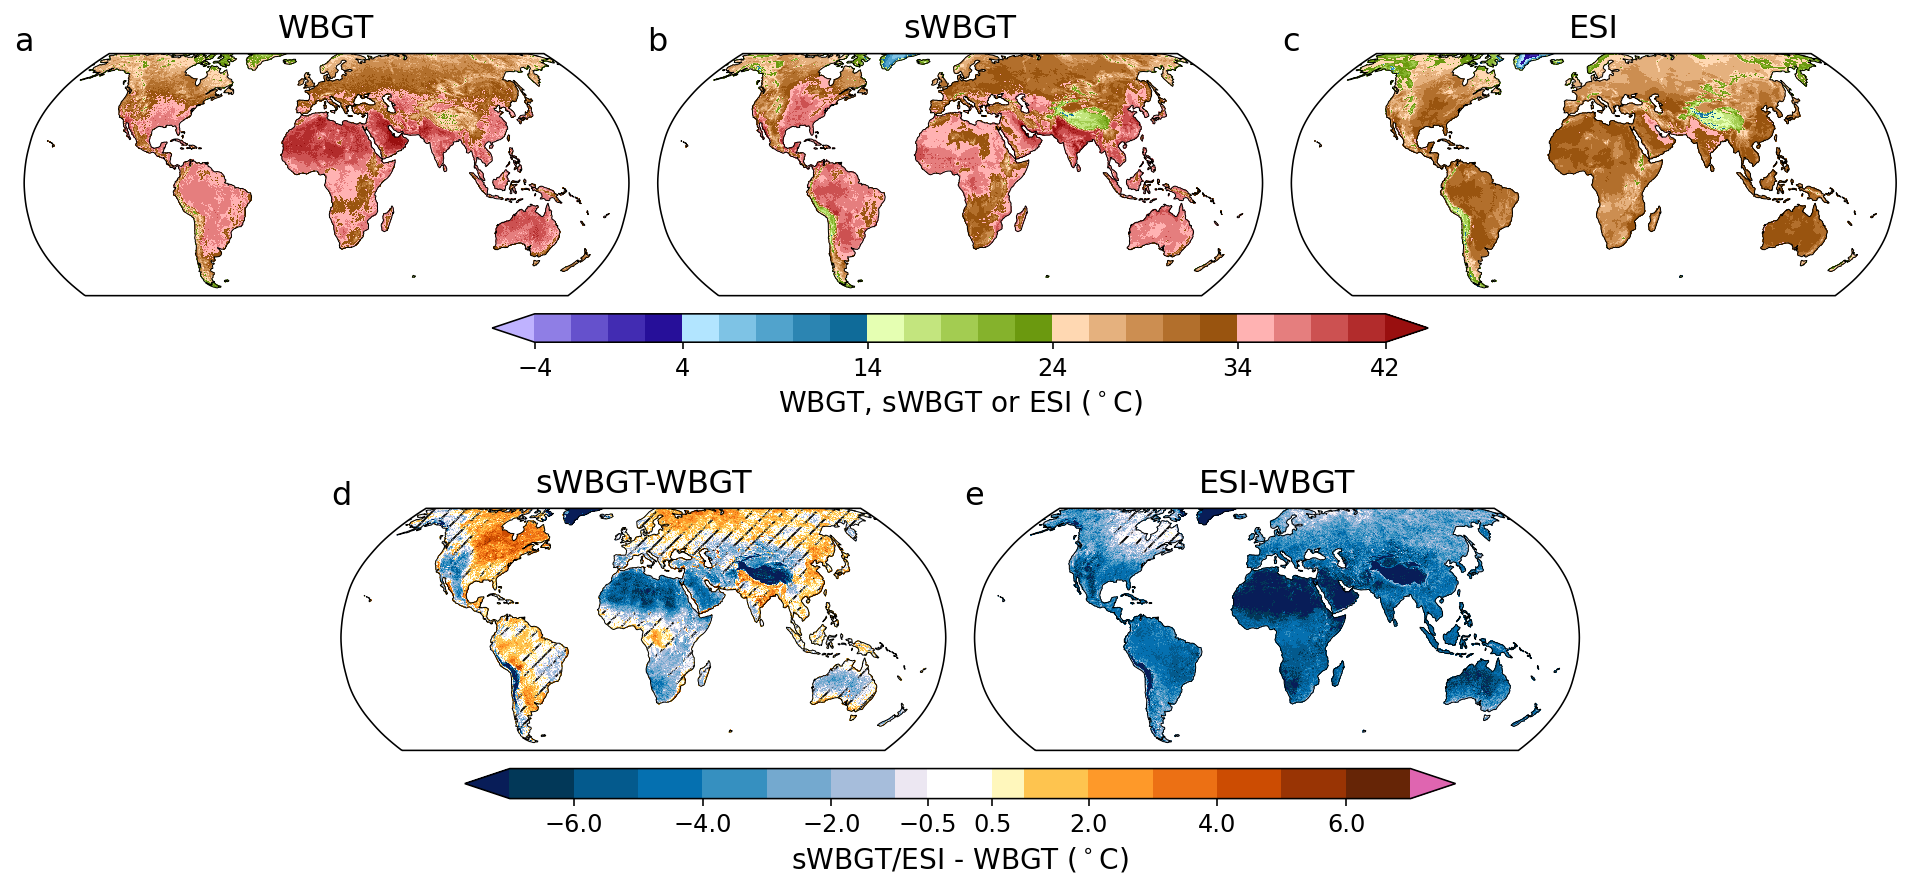

In [5]:
plot(gev)

# Figure caption

(a) WBGT, (b) sWBGT and (c) ESI return levels corresponding to a 1-in-30-year event, and their differences (sWBGT-WBGT in panel d; ESI-WBGT in panel e). Areas with biases not statistically significant at 5% level are hatched in d-e. Data of the whole year during 1990-2019 are included for analysis.